In [1]:
%pylab notebook --no-import-all
%matplotlib notebook

from astropy import units as u
from astropy import constants as const

Populating the interactive namespace from numpy and matplotlib


In [2]:
def lens(s, sp):
    f   = 1 / (s[0]**(-1) + sp[0]**(-1))
    
    Ds  = (sp[0]**2) / (s[0] + sp[0])**2
    Dsp = (s[0]**2) / (s[0] + sp[0])**2
    
    df2 = (Ds * s[1])**2 + (Dsp * sp[1])**2
    
    return [f, np.sqrt(df2)]

def lens_raw(s, sp):
    return 1 / (s**(-1) + sp**(-1))

def lens_known(f, s):
    sp  = 1 / (f**(-1) - s[0]**(-1))
    Dsp = s[1] * (s[0]**-2) * (f**(-1) - s[0]**(-1))**(-2)

    return [sp, Dsp]

this is kinda bullshit, but hey it works

In [3]:
class Generator(object):
    def __init__(self, seed_len, tol, length1, length2):
        self.seed      = seed_len
        self.tolerance = tol
        self.f1        = length1
        self.f2        = length2

    # The generator function
    # Picks plausible lengths b & c where
    # b = s1' + s2 and c = s2'
    def generate(self, n, ds=0.2):
        arr     = np.zeros(n).tolist()
        
        # firstly, find theoretical lensmaker equation values from initial length s1
        sp, dsp = self.lens(self.f1, self.seed, ds)
        
        # now, generate n sets of {b, c}
        for i in range(n):
            
            # generates a plausible enough normally-distributed b (with a tolerance)
            b       = np.around(self.pick(4*sp, 2.), 1)
        
            mu, smu = self.lens(self.f2, b - sp, np.sqrt(dsp**2 + ds))
            
            # generates a plausible enough normally-distributed c (with a tolerance) depending on the image
            c       = self.pick(mu, smu)
            
            # add values to the set
            arr[i]  = np.array([b, np.around(c, 1)])
        
        return np.array(arr)

    def lens(self, f, s, ds):
        sp  = 1 / (f**(-1) - s**(-1))
        Dsp = ds * (s**-2) * (f**(-1) - s**(-1))**(-2)

        return [np.around(sp, 1), Dsp]
    
    def pick(self, mu, r):
        val = np.random.normal(mu, r)
        
        if (np.abs((val - mu) / (r)) > (self.tolerance)):
            return self.pick(mu, r)
        else:
            return val

In [6]:
gen = Generator(11.3, 2.5, 4.8, 12.7)

res = gen.generate(10)
res

array([[ 34.3,  24.8],
       [ 34.8,  24.7],
       [ 36. ,  23.4],
       [ 29. ,  32.8],
       [ 37. ,  23.1],
       [ 32.2,  27. ],
       [ 34.5,  24.9],
       [ 35.1,  24.8],
       [ 36.8,  22.8],
       [ 29.4,  29.7]])

In [7]:
dx1 = 0.2*u.cm
dx2 = 0.3*u.cm

f1  = 4.8 * u.cm
f2  = 12.7 * u.cm

s_1  = [6.0*u.cm, dx1]
sp_1 = [24.2*u.cm, dx1]

s_2  = [13.6*u.cm, dx2]
sp_2 = [23.4*u.cm, dx2]

# Actually bullshit right here
a1   = [11.3*u.cm, dx1]
b1   = [30.6*u.cm, dx1]
c1   = [30.3*u.cm, dx1]

a2   = [11.3*u.cm, dx1]
b2   = [31.9*u.cm, dx1]
c2   = [27.8*u.cm, dx1]

a3   = [11.3*u.cm, dx1]
b3   = [34.9*u.cm, dx1]
c3   = [24.4*u.cm, dx1]

<IPython.core.display.Javascript object>


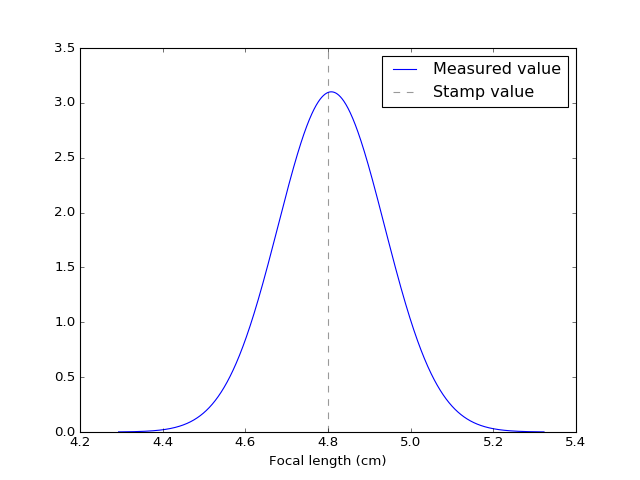

In [8]:
mu, s = lens(s_1, sp_1)

mu    = mu.value
s     = s.value

x     = np.linspace(mu - 4*s, mu + 4*s, 1000)
plt.plot(x, mlab.normpdf(x, mu, s), label='Measured value')
plt.axvline(4.8, ls='--', color='k', alpha=0.4, label='Stamp value')

plt.xlabel('Focal length (cm)')
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


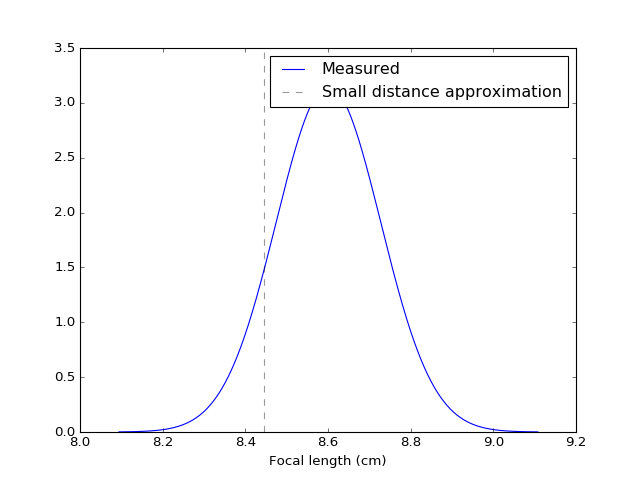

True

In [9]:
mu, s = lens(s_2, sp_2)
raw   = lens_raw(12.7*u.cm, 25.2*u.cm).value

mu    = mu.value
s     = s.value

x     = np.linspace(mu - 4*s, mu + 4*s, 1000)

plt.plot(x, mlab.normpdf(x, mu, s), label='Measured')
plt.axvline(raw, ls='--', color='k', alpha=0.4, label='Small distance approximation')

plt.xlabel('Focal length (cm)')
plt.legend(loc='upper right')

np.abs(mu - raw) > s

In [10]:
N     = 1000
vals0 = np.arange(N)
vals1 = np.arange(1, N)

def gaussmean(a):
    return (1/2)*a[-1]*(a[-1] + 1)

def oddsum(a):
    if a[0] == 0:
        return sum(2*a + 1)
    elif a[0] == 1:
        return sum(2*a - 1)
    else:
        raise Exception('Nope')

def evensum(a):
    return sum(2*a)

<IPython.core.display.Javascript object>


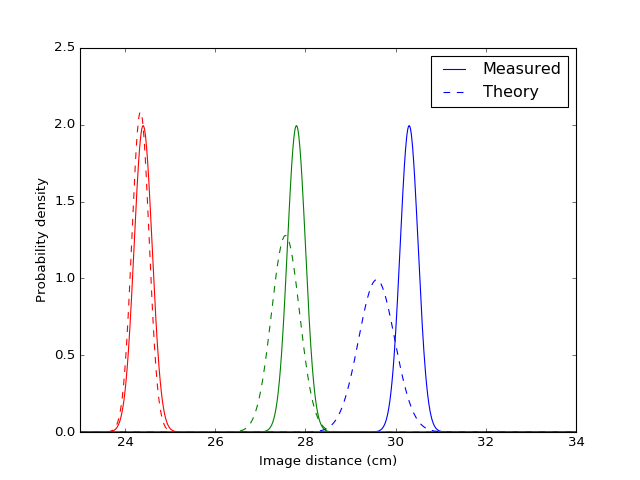

In [11]:
s1p_1 = lens_known(f1, a1)
s2_1  = [b1[0] - s1p_1[0], np.sqrt(b1[1]**2 + s1p_1[1]**2)]
s2p_1 = lens_known(f2, s2_1)

s1p_2 = lens_known(f1, a2)
s2_2  = [b2[0] - s1p_2[0], np.sqrt(b2[1]**2 + s1p_2[1]**2)]
s2p_2 = lens_known(f2, s2_2)

s1p_3 = lens_known(f1, a3)
s2_3  = [b3[0] - s1p_3[0], np.sqrt(b3[1]**2 + s1p_3[1]**2)]
s2p_3 = lens_known(f2, s2_3)

x = np.linspace(23, 35, 1000)

plt.plot(x, mlab.normpdf(x, c1[0].value, c1[1].value), 'b-', label='Measured')
plt.plot(x, mlab.normpdf(x, c2[0].value, c2[1].value), 'g-')
plt.plot(x, mlab.normpdf(x, c3[0].value, c3[1].value), 'r-')

plt.plot(x, mlab.normpdf(x, s2p_1[0].value, s2p_1[1].value), 'b--', label='Theory')
plt.plot(x, mlab.normpdf(x, s2p_2[0].value, s2p_2[1].value), 'g--')
plt.plot(x, mlab.normpdf(x, s2p_3[0].value, s2p_3[1].value), 'r--')

plt.xlabel('Image distance (cm)')
plt.ylabel('Probability density')
plt.xlim(xmin=23, xmax=34)

plt.legend(loc='upper right')